Introdução
No microcurso Intro to SQL, você aprendeu a usar funções de agregação, que realizam cálculos com base em conjuntos de linhas. Neste tutorial, você aprenderá a definir funções analíticas, que também operam em um conjunto de linhas. No entanto, ao contrário das funções agregadas, as funções analíticas retornam um valor (potencialmente diferente) para cada linha na tabela original.

As funções analíticas nos permitem realizar cálculos complexos com uma sintaxe relativamente direta. Por exemplo, podemos calcular rapidamente médias móveis e totais em execução, entre outras quantidades.

## Syntax

---



Para entender como escrever funções analíticas, trabalharemos com uma pequena tabela contendo dados de duas pessoas diferentes que estão treinando para uma corrida. A coluna id identifica cada corredor, a coluna date contém o dia da sessão de treino e time mostra o tempo (em minutos) que o corredor dedicou ao treino. Digamos que gostaríamos de calcular uma média móvel dos tempos de treinamento para cada corredor, onde sempre tomamos a média das sessões de treinamento atuais e anteriores. Podemos fazer isso com a seguinte consulta:

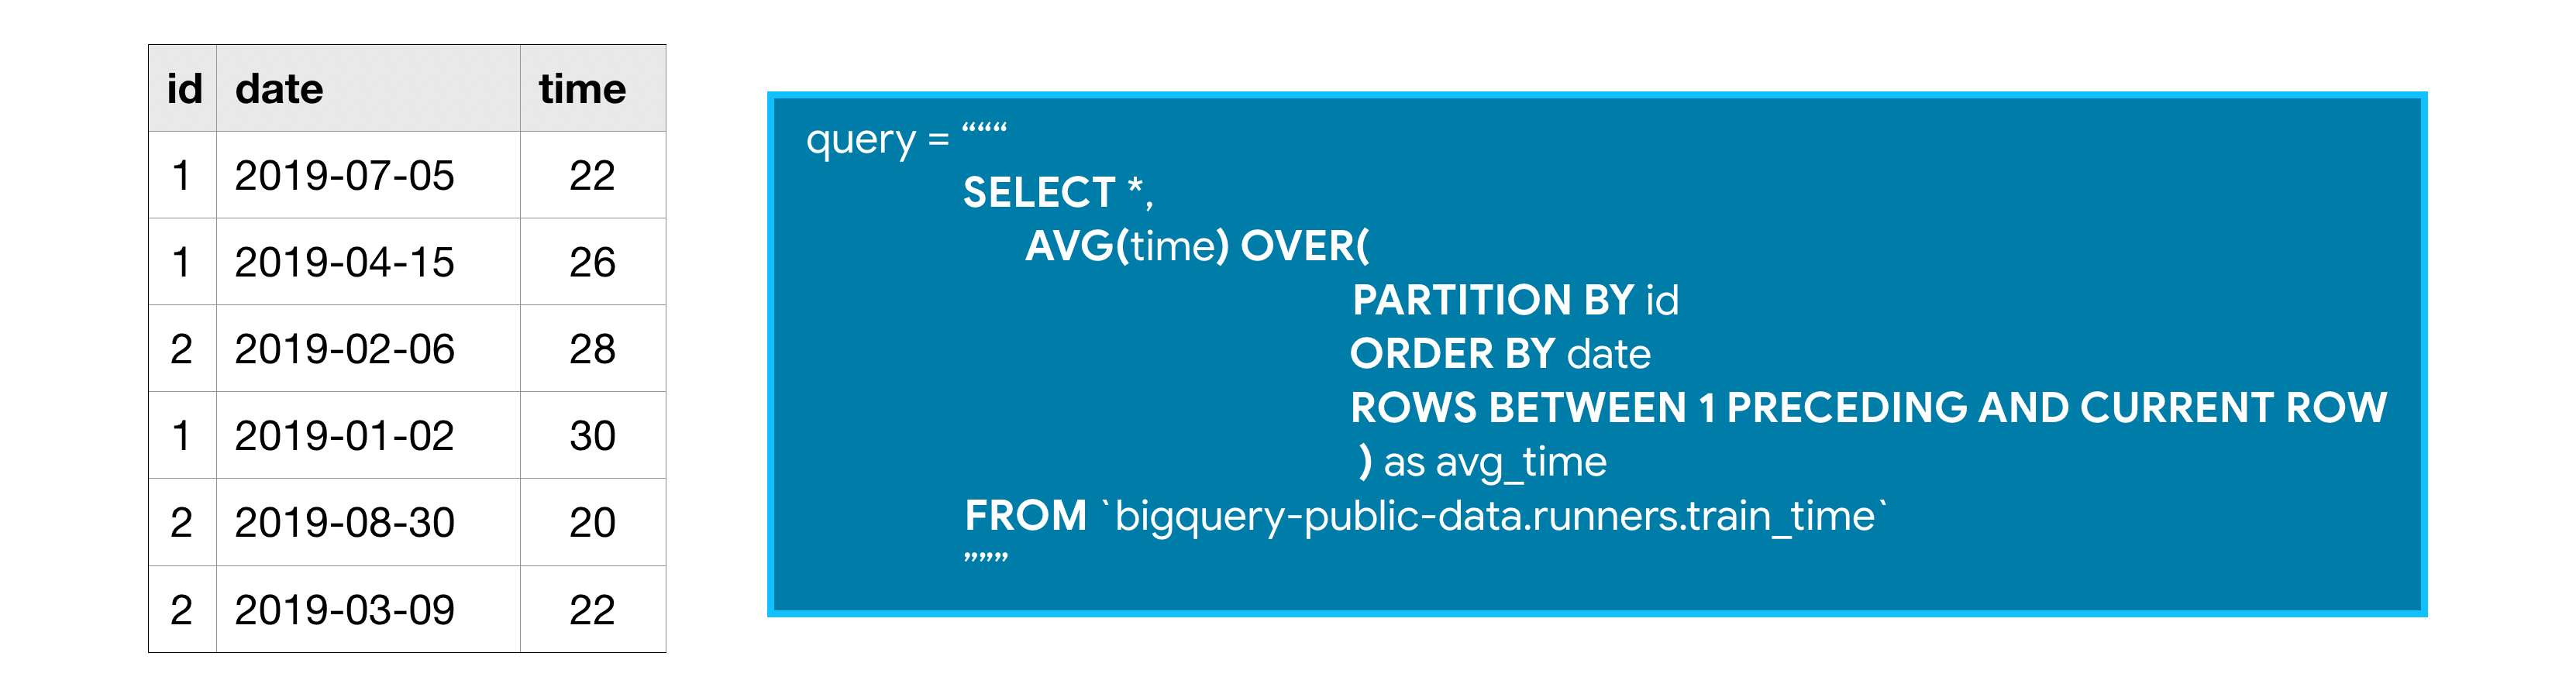

Todas as funções analíticas possuem uma cláusula OVER, que define os conjuntos de linhas usados em cada cálculo. A cláusula OVER tem três partes (opcionais):

* A cláusula PARTITION BY divide as linhas da tabela em diferentes grupos. Na consulta acima, dividimos por id para que os cálculos sejam separados por runner.
* A cláusula ORDER BY define uma ordenação dentro de cada partição. Na consulta de amostra, a ordenação pela coluna de data garante que as sessões de treinamento anteriores apareçam primeiro.
* A cláusula final (ROWS BETWEEN 1 PRECEDING AND CURRENT ROW) é conhecida como cláusula de quadro de janela. Ele identifica o conjunto de linhas usado em cada cálculo. Podemos nos referir a esse grupo de linhas como uma janela. (Na verdade, as funções analíticas às vezes são chamadas de funções de janela analíticas ou simplesmente funções de janela!)

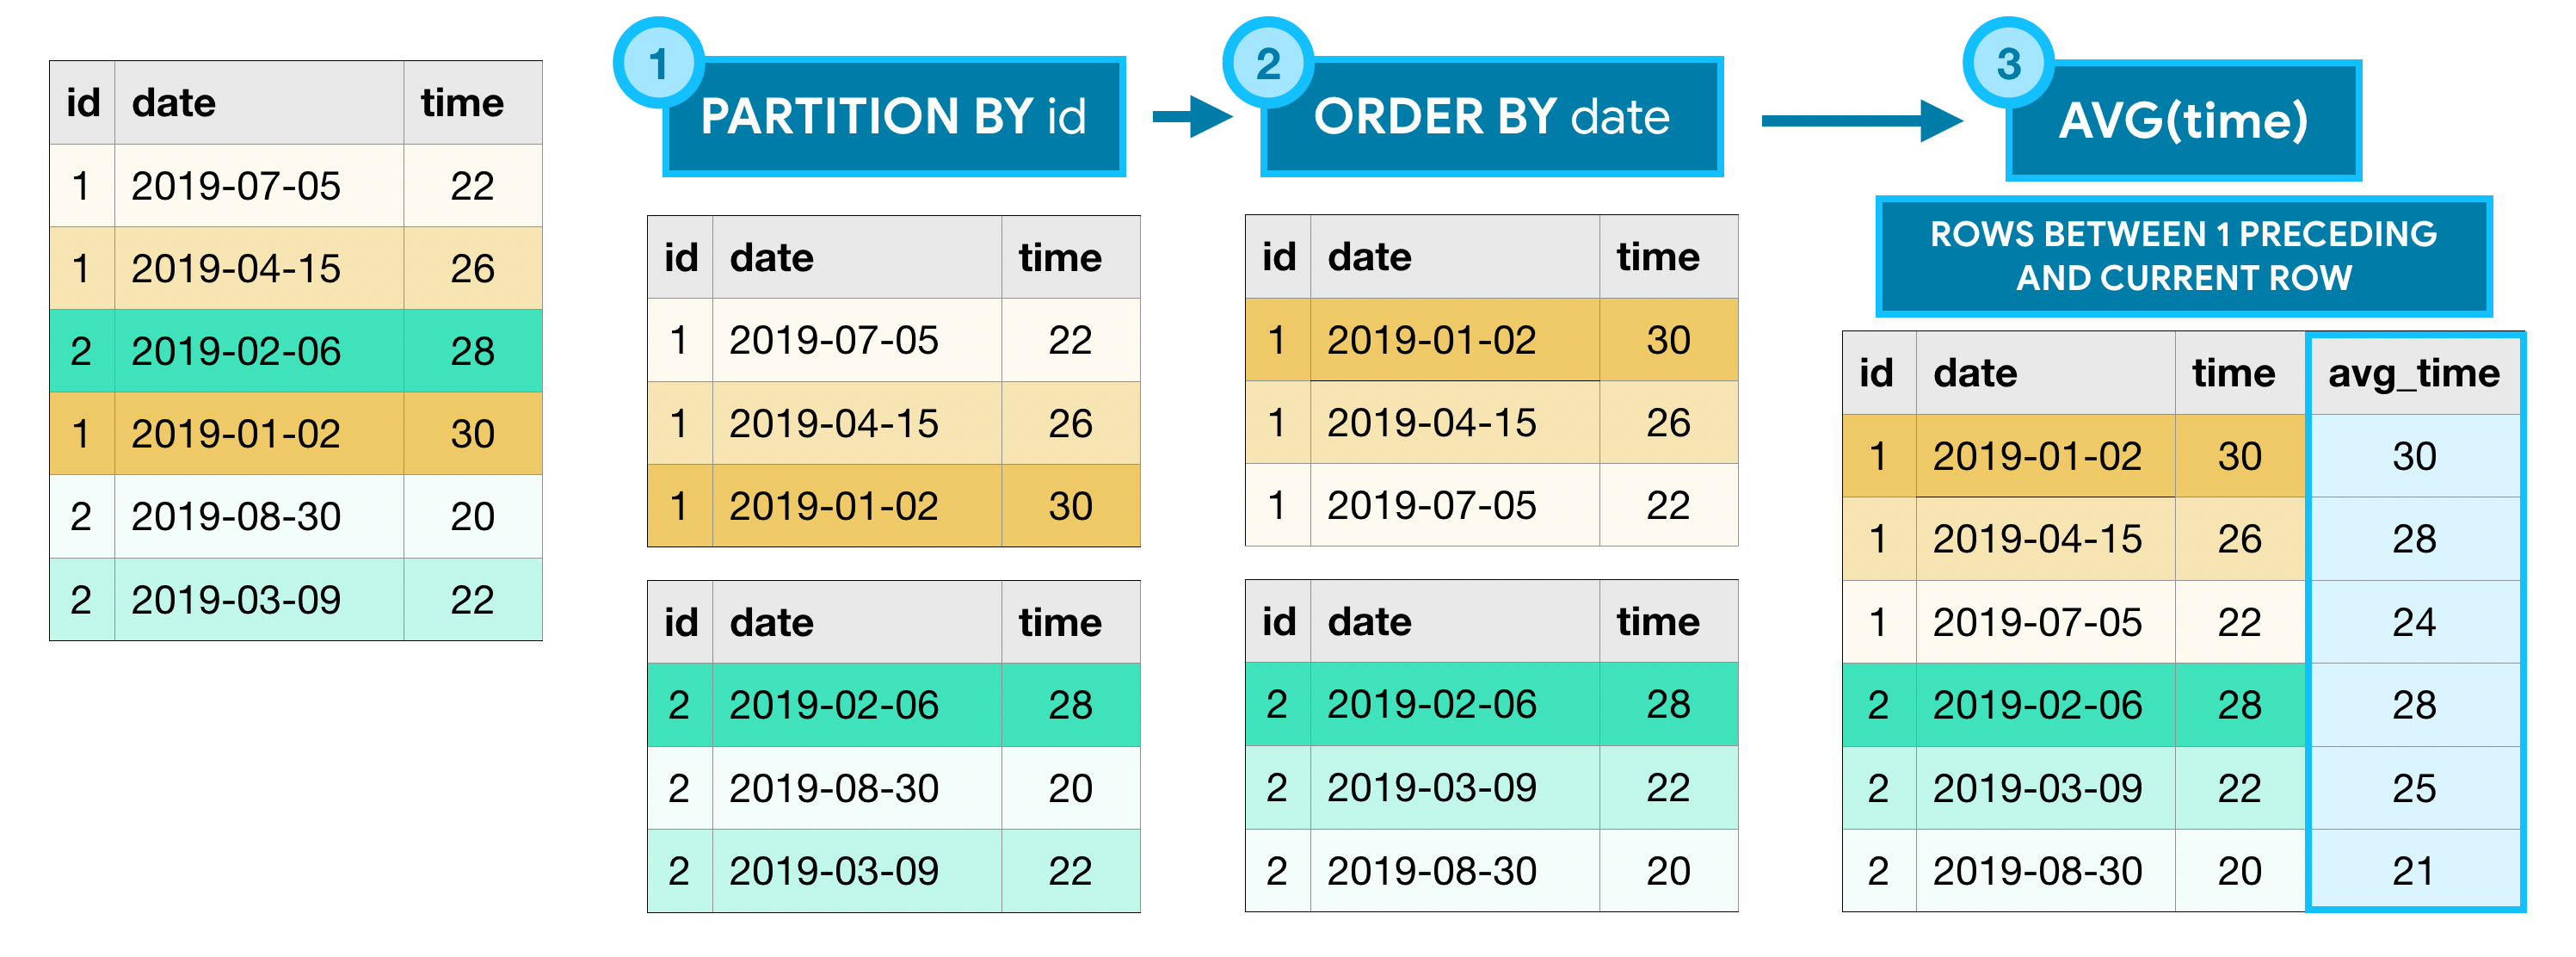

## (More on) window frame clauses

---



Há muitas maneiras de escrever cláusulas de janela:

* LINHAS ENTRE 1 LINHA ANTECEDENTE E ATUAL - a linha anterior e a linha atual.
* LINHAS ENTRE 3 ANTECEDENTES E 1 SEGUINTE - as 3 linhas anteriores, a linha atual e a linha seguinte.
* LINHAS ENTRE O ANTECEDENTE ILIMITADO E O SEGUINTE ILIMITADO - todas as linhas na partição.

Claro, esta não é uma lista exaustiva, e você pode imaginar que existem muito mais opções! No código abaixo, você verá algumas dessas cláusulas em ação.

## Três tipos de funções analíticas

---

O exemplo acima usa apenas uma das muitas funções analíticas. O BigQuery é compatível com uma ampla variedade de funções analíticas, e exploraremos algumas aqui. Para uma lista completa, você pode dar uma olhada na documentação.

1. Funções agregadas analíticas
Como você deve se lembrar, AVG() (do exemplo acima) é uma função agregada. A cláusula OVER é o que garante que ela seja tratada como uma função analítica (agregada). As funções agregadas recebem todos os valores dentro da janela como entrada e retornam um único valor.

* MIN() (ou MAX()) - Retorna o mínimo (ou máximo) dos valores de entrada
* AVG() (ou SUM()) - Retorna a média (ou soma) dos valores de entrada
* COUNT() - Retorna o número de linhas na entrada

2. Funções de navegação analítica
As funções de navegação atribuem um valor com base no valor em uma linha (geralmente) diferente da linha atual.

* FIRST_VALUE() (ou LAST_VALUE()) - Retorna o primeiro (ou último) valor na entrada
* LEAD() (e LAG()) - Retorna o valor em uma linha subsequente (ou anterior)

3. Funções de numeração analítica
As funções de numeração atribuem valores inteiros a cada linha com base na ordenação.

* ROW_NUMBER() - Retorna a ordem em que as linhas aparecem na entrada (começando com 1)
* RANK() - Todas as linhas com o mesmo valor na coluna de ordenação recebem o mesmo valor de classificação, onde a próxima linha recebe um valor de classificação que é incrementado pelo número de linhas com o valor de classificação anterior.

## Exemplo

---


Trabalharemos com o conjunto de dados de dados abertos de São Francisco. Começamos revisando as primeiras linhas da tabela bikeshare_trips. (O código correspondente está oculto, mas você pode reexibi-lo clicando no botão "Código" abaixo.)


In [ ]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "san_francisco" dataset
dataset_ref = client.dataset("san_francisco", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "bikeshare_trips" table
table_ref = dataset_ref.table("bikeshare_trips")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the table
client.list_rows(table, max_results=5).to_dataframe()

Cada linha da tabela corresponde a uma viagem de bicicleta diferente, e podemos usar uma função analítica para calcular o número acumulado de viagens para cada data em 2015.

In [ ]:
# Query to count the (cumulative) number of trips per day
num_trips_query = """
                  WITH trips_by_day AS
                  (
                  SELECT DATE(start_date) AS trip_date,
                      COUNT(*) as num_trips
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE EXTRACT(YEAR FROM start_date) = 2015
                  GROUP BY trip_date
                  )
                  SELECT *,
                      SUM(num_trips) 
                          OVER (
                               ORDER BY trip_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
                               ) AS cumulative_trips
                      FROM trips_by_day
                  """

# Run the query, and return a pandas DataFrame
num_trips_result = client.query(num_trips_query).result().to_dataframe()
num_trips_result.head()

A consulta usa uma expressão de tabela comum (CTE) para calcular primeiro o número diário de viagens. Em seguida, usamos SUM() como uma função agregada.

* Como não há cláusula PARTITION BY, a tabela inteira é tratada como uma única partição.
* A cláusula ORDER BY ordena as linhas por data, onde as datas anteriores aparecem primeiro.
* Ao definir a cláusula do quadro de janela como ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW, garantimos que todas as linhas até e incluindo a data atual sejam usadas para calcular a soma (cumulativa). (Observação: se você ler a documentação, verá que esse é o comportamento padrão e, portanto, a consulta retornará o mesmo resultado se deixarmos de fora esta cláusula do quadro de janela.)

A próxima consulta rastreia as estações onde cada bicicleta começou (em start_station_id) e terminou (em end_station_id) no dia 25 de outubro de 2015.

In [ ]:
# Query to track beginning and ending stations on October 25, 2015, for each bike
start_end_query = """
                  SELECT bike_number,
                      TIME(start_date) AS trip_time,
                      FIRST_VALUE(start_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS first_station_id,
                      LAST_VALUE(end_station_id)
                          OVER (
                               PARTITION BY bike_number
                               ORDER BY start_date
                               ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING
                               ) AS last_station_id,
                      start_station_id,
                      end_station_id
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE DATE(start_date) = '2015-10-25' 
                  """

# Run the query, and return a pandas DataFrame
start_end_result = client.query(start_end_query).result().to_dataframe()
start_end_result.head()

A consulta usa FIRST_VALUE() e LAST_VALUE() como funções analíticas.

* A cláusula PARTITION BY divide os dados em partições com base na coluna bike_number. Como essa coluna contém identificadores exclusivos para as bicicletas, isso garante que os cálculos sejam realizados separadamente para cada bicicleta.
* A cláusula ORDER BY coloca as linhas dentro de cada partição em ordem cronológica.
* Como a cláusula do quadro de janela é ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING, para cada linha, toda a sua partição é usada para realizar o cálculo. (Isso garante que os valores calculados para linhas na mesma partição sejam idênticos.)